### Overview
Lending Club loan dataset is an imbalanced dataset with good and bad loan ratio around 8:2. The purpose of this task is to distinguish bad loans from good loans. There are several approaches to deal with this imbalanced probelm: 

    1. Change the evaluation metric from accuracy to F1 score, since F1 score is a balanced mesaure of precision and recall. 
    2. Under, over or SMOTE sampling the training dataset to make classes balance, then train the model.
    3. Put more weight on the minority class.
    
Since imbalance ratio at 8:2 is not very severe, this notebook is modeled on the original imbalanced dataset and see what best approach it can get. The modeling steps are:

    1. Check correlation between description features and target feature
    2. Select best model from a list of candidates
    3. Model parameter tuning
    4. Threshold selection
    
After all these steps, the final model is Logistic Regression with L1(Lasso) penalty C=1 and threshold 0.3. 
The best training performance are: F1: 69.04, Precision: 76.61, Recall: 62.83, AUC: 78.78, Accuracy: 87.84. 
The testing performance are: F1: 68.43, Precision: 75.75, Recall: 62.39, AUC: 78.46, Accuracy: 87.63. 
There is no big disparency between training and testing performance, which means overfitting is prohibited.

According to feature importance, people with high last_fico_range_high and annual_inc are less likely to default on loans, applicatnts with debt_settlement_flag Y are more likely to default on loans.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("LendingClub_2011_2014_cleanedData.csv")
df.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,fico_range_high,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,debt_settlement_flag_N,debt_settlement_flag_Y
0,10400,6.99,321.08,8,58000.0,1,14.92,0,710,714,...,0,0,0,0,0,0,0,1,1,0
1,15000,12.39,336.64,10,78000.0,0,12.03,0,750,754,...,0,0,0,0,0,0,0,1,1,0
2,9600,13.66,326.53,10,69000.0,0,25.81,0,680,684,...,0,0,0,0,0,0,1,0,1,0
3,12800,17.14,319.08,10,125000.0,0,8.31,1,665,669,...,0,0,0,0,0,0,0,1,1,0
4,21425,15.59,516.36,6,63800.0,0,18.49,0,685,689,...,0,0,0,0,0,0,0,1,1,0


### 1. check correlation between target feature and description features then rank absolute value from high to low

In [3]:
df[df.columns[:]].corr()['loan_status'][:].abs().nlargest(n=10, keep='first')

loan_status               1.000000
last_fico_range_high      0.566410
last_fico_range_low       0.494946
debt_settlement_flag_N    0.303142
debt_settlement_flag_Y    0.303142
int_rate                  0.234969
term_ 36 months           0.156282
term_ 60 months           0.156282
fico_range_low            0.110235
fico_range_high           0.110234
Name: loan_status, dtype: float64

No feature has high correlation with loan_status

### read splitted training and testing set

In [4]:
X_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('x_test.csv')
y_test = pd.read_csv('y_test.csv')

In [5]:
y_train.value_counts()

loan_status
0              127625
1               27453
dtype: int64

In [6]:
y_test.value_counts()

loan_status
0              63813
1              13726
dtype: int64

### 2. Select model with highest F1 score using 5-fold Cross Validation

In [7]:
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier(max_depth=10)))
models.append(('RF', RandomForestClassifier(max_depth=10)))#slow
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) slow

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.647674 (0.006004)
LDA: 0.635764 (0.006295)
CART: 0.635839 (0.004437)
RF: 0.628152 (0.005667)
NB: 0.341344 (0.010628)


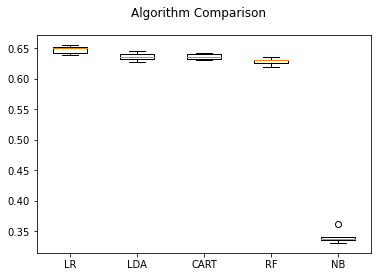

In [8]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### ===> Logistic Regression performed better than other models.

#### check the detailed performance of the logistic regression on trainining dataset 

* define a function which could return confusion matrix and other measurements.

In [9]:
def plot_confusion_matrix(pred, act, title):
    import seaborn as sns
    
    cnf_matrix = confusion_matrix(pred, act, labels=[0, 1])
    precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
    recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
    f1 = 2*precision*recall/(precision+recall)
    aucRoc = roc_auc_score(pred, act)
    acc = (cnf_matrix[0,0] + cnf_matrix[1,1])/cnf_matrix.sum()
    print('')
    print(title)

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(cnf_matrix, annot=True, annot_kws={"size": 16},fmt='g') # font size
    #plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    plt.show()
    
    print('Mesurements:')
    method_dict = {'F1': '{:.2f}'.format(f1*100), 
               'Precision': '{:.2f}'.format(precision*100), 
               'Recall': '{:.2f}'.format(recall*100),
               'AUC': '{:.2f}'.format(aucRoc*100), 
               'Accuracy': '{:.2f}'.format(acc*100)
              }
    return pd.DataFrame(method_dict,index=['values'])


In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)


Logistic Regression: Train Performance


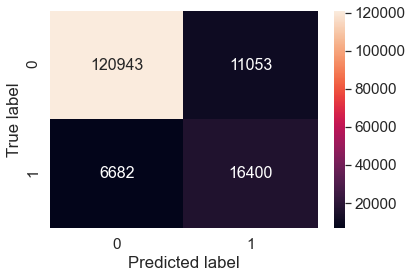

Mesurements:


,F1,Precision,Recall,AUC,Accuracy
values,64.91,59.74,71.05,81.34,88.56


In [11]:
plot_confusion_matrix(y_pred, y_train, 'Logistic Regression: Train Performance')


Logistic Regression: Test Performance


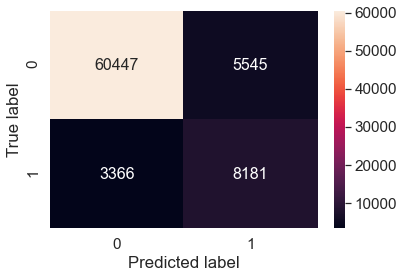

Mesurements:


,F1,Precision,Recall,AUC,Accuracy
values,64.74,59.60,70.85,81.22,88.51


In [12]:
y_test_pred = lr.predict(X_test)

plot_confusion_matrix(y_test_pred, y_test, 
                      'Logistic Regression: Test Performance')

#### ===> performance on logistic regression: 

* training F1 score 64.91
* testing F1 score 64.74

### 2. tune parameter 
#### penalty
L1 regularization may not be better than L2 in principle, but in practice one good reason to prefer L1 is that it can save you time and money. L1 regularization typically leaves you with a smaller set of predictors, while L2 might just leave you with smaller coefficients on most if not all of your potential predictors.

regularization: 0.01 f1:  0.6324151640158046 std:  0.006268871332884192
regularization: 0.1 f1:  0.6480196747679133 std:  0.005893072488315733
regularization: 1 f1:  0.6507568243991375 std:  0.006305248739651821
regularization: 10 f1:  0.6507088854301633 std:  0.0065946206080626756
regularization: 100 f1:  0.6506745759702948 std:  0.0065273436661144124


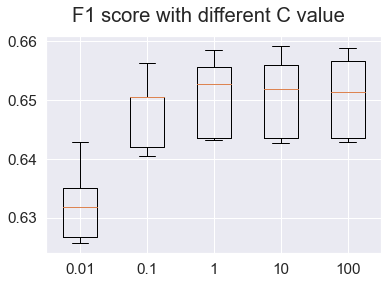

In [13]:
def c_scores(X_train, y_train):
    #penalty range
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    regularization = []
    results = []
    for c_param in c_param_range:
        
        lr = LogisticRegression(C = c_param, penalty='l1',solver='saga')
        kfold = model_selection.KFold(n_splits=5, random_state=seed)
        cv_results = model_selection.cross_val_score(lr, X_train, y_train, cv=kfold, scoring='f1')
        
        results.append(cv_results)
        regularization.append(c_param)
        print('regularization:', c_param, 'f1: ', cv_results.mean(), 'std: ', cv_results.std())

    fig = plt.figure()
    fig.suptitle('F1 score with different C value')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(regularization)
    plt.show()

c_scores(X_train, y_train)


Logistic Regression(C=1,L1): Train Performance


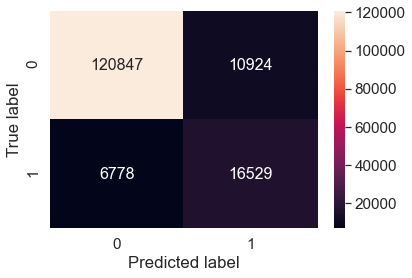

Mesurements:


,F1,Precision,Recall,AUC,Accuracy
values,65.13,60.21,70.92,81.31,88.59


In [14]:
lr = LogisticRegression(C = 1, penalty='l1',solver='saga')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
plot_confusion_matrix(y_pred, y_train, 'Logistic Regression(C=1,L1): Train Performance')


Logistic Regression(C=1,L1): Test Performance


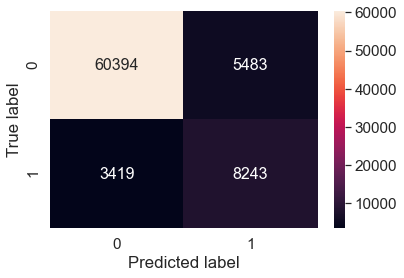

Mesurements:


,F1,Precision,Recall,AUC,Accuracy
values,64.94,60.05,70.68,81.18,88.52


In [15]:
y_test_pred = lr.predict(X_test)

plot_confusion_matrix(y_test_pred, y_test, 
                      'Logistic Regression(C=1,L1): Test Performance')

#### ===> after tuning parameter c1: 

* training F1 score increased from 64.91 to 65.12
* testing F1 score increased from 64.74 to 64.94

### 3. threshold

In [16]:
def best_threshod(y_pred_proba, y_train, threshold_range):
    Precision = []
    Recall = []
    F1 = []
    AUC = []
    Accuracy = []
    for i  in threshold_range:
        y_pred = y_pred_proba[:,1] > i
        cnf_matrix = confusion_matrix(y_pred, y_train)
    
        precision = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
        recall = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
        f1 = 2*precision*recall/(precision+recall)
        aucRoc = roc_auc_score(y_pred, y_train)
        acc = (cnf_matrix[0,0] + cnf_matrix[1,1])/cnf_matrix.sum()
    
        F1.append(f1)
        Precision.append(precision)
        Recall.append(recall)
        AUC.append(aucRoc)
        Accuracy.append(acc)

    method_dict = {'Threshold':threshold_range,
                   'F1': F1, 
                   'Precision': Precision, 
                   'Recall': Recall,
                   'AUC': AUC,
                   'Accuracy':Accuracy
                  }
    df = pd.DataFrame(method_dict)
    df2 = df.melt('Threshold', var_name='cols',  value_name='vals')
    
    sns.lineplot(x="Threshold", y="vals", hue='cols',data=df2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    print('Best threshold based on highest F1 score:')
    return df[df.F1 == df.F1.max()]

Best threshold based on highest F1 score:


,Threshold,F1,Precision,Recall,AUC,Accuracy
2,0.3,0.690401,0.628335,0.766073,0.787763,0.878371


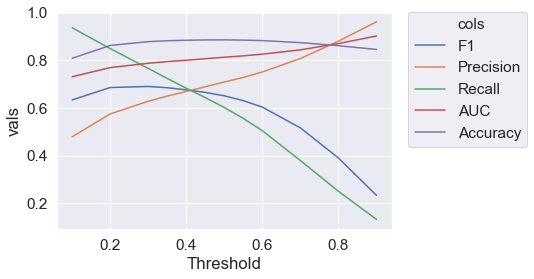

In [17]:
threshold_range = [0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]
y_pred_proba = lr.predict_proba(X_train)

best_threshod(y_pred_proba, y_train, threshold_range)

====> When threshold = 0.3, training model has the highest F1 score 


Logistic Regression(C=1, L1, Threshold=0.3): Train Performance


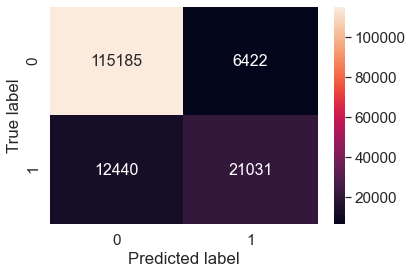

Mesurements:


,F1,Precision,Recall,AUC,Accuracy
values,69.04,76.61,62.83,78.78,87.84


In [18]:
threshold = 0.3
y_proba = lr.predict_proba(X_train)
y_pred = y_proba[:,1] > threshold

plot_confusion_matrix(y_pred, y_train, 'Logistic Regression(C=1, L1, Threshold=0.3): Train Performance')


Logistic Regression(C=100, Threshold=0.3): Test Performance


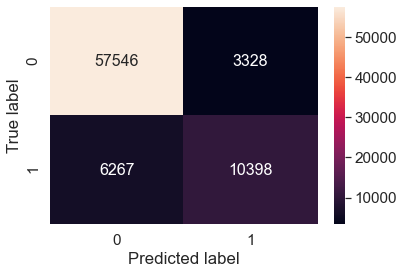

Mesurements:


,F1,Precision,Recall,AUC,Accuracy
values,68.43,75.75,62.39,78.46,87.63


In [19]:
y_test_proba = lr.predict_proba(X_test)
y_test_pred = y_test_proba[:,1] > threshold

plot_confusion_matrix(y_test_pred, y_test, 'Logistic Regression(C=1, Threshold=0.3): Test Performance')

#### ===> after adjust threshold:

* training F1 score increased from 65.12 to 69.04
* testing F1 score increased from 64.94 to 68.43

The logistic regression model built on imbalanced dataset has testing performance f1 = 68.43, precision = 75.75 and recall = 62.39 with area under ROC curve 78.46% which is a acceptable outcome.

### Feature importance

<AxesSubplot:title={'center':'Feature importance'}>

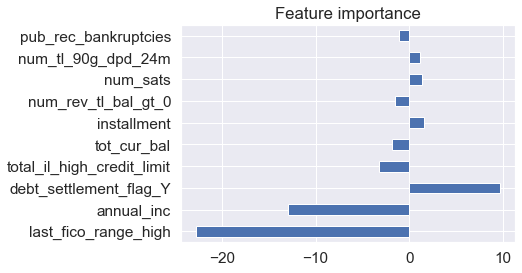

In [20]:
model = LogisticRegression(C = 1, penalty='l1',solver='saga')
model.fit(X_train, y_train)
feat_importances = pd.Series(model.coef_[0], index=X_train.columns)
important = list(feat_importances.abs().nlargest(10).index)
feat_importances[important].plot(kind='barh', title = 'Feature importance')

People with high last_fico_range_high and annual_inc are less likely to default on loans, applicatnts with debt_settlement_flag Y are more likely to default on loans.